In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from collections import OrderedDict
from tensorboardX import SummaryWriter
from torchvision import transforms
import torchvision
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torch
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from torch.nn import init
from sklearn.metrics import roc_auc_score, accuracy_score

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
# load data
print('loading train')
train_df = pd.read_csv('../input/train.csv')
print('loading test')
test_df = pd.read_csv('../input/test.csv')
print(train_df)
print(test_df)

['train.csv', 'sample_submission.csv', 'test.csv']
loading train
loading test
             ID_code  target    var_0   ...     var_197  var_198  var_199
0            train_0       0   8.9255   ...      8.5635  12.7803  -1.0914
1            train_1       0  11.5006   ...      8.7889  18.3560   1.9518
2            train_2       0   8.6093   ...      8.2675  14.7222   0.3965
3            train_3       0  11.0604   ...     10.2922  17.9697  -8.9996
4            train_4       0   9.8369   ...      9.5031  17.9974  -8.8104
5            train_5       0  11.4763   ...      9.7670  12.5809  -4.7602
6            train_6       0  11.8091   ...      9.1143  10.8869  -3.2097
7            train_7       0  13.5580   ...      9.4237   8.6624   3.4806
8            train_8       0  16.1071   ...      8.1975  19.5114   4.8453
9            train_9       0  12.5088   ...      7.9133  16.2375  14.2514
10          train_10       0   5.0702   ...      9.2553  14.2914  -7.6652
11          train_11       0  12.7

In [2]:
train_drop_label = train_df.drop(['target', 'ID_code'], axis=1) # Features
test_drop_label = test_df.drop(['ID_code'], axis=1)
all_df = pd.concat([train_drop_label, test_drop_label], axis=0)
train_len = train_df.count()[0]
test_len= test_df.count()[0]
print(train_len, test_len)
scaler = preprocessing.StandardScaler()
all_scaled = pd.DataFrame(scaler.fit_transform(all_df), columns=all_df.columns)

train_x,test_x,train_y,test_y= train_test_split(all_scaled[:train_len], train_df.target, test_size=.01, shuffle=True)

validation_x_tensor = torch.Tensor(test_x.values)
train_x_tensor = torch.Tensor(train_x.values)
test_x_tensor = torch.Tensor(all_scaled[train_len:].values)

200000 200000


In [3]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.model = nn.Sequential(
             nn.Linear(200, 60),
             nn.ReLU(),
             nn.BatchNorm1d(60),
             nn.Linear(60, 40),
             nn.ReLU(),
             nn.BatchNorm1d(40),
             nn.Linear(40, 20),
             nn.ReLU(),
             nn.BatchNorm1d(20),
             nn.Linear(20, 1),
             nn.Sigmoid(),
        )
        init.xavier_uniform_(self.model[0].weight)
        init.xavier_uniform_(self.model[3].weight)
        init.xavier_uniform_(self.model[6].weight)
        init.xavier_uniform_(self.model[9].weight)


    def forward(self, x):
        return self.model(x)
    
def train(train_loader, model, loss_fn, optimizer, scheduler):
    model.train(True)
    total_loss = 0

    for data, target in train_loader:
        data = data.cuda()
        target = target.cuda()
        optimizer.zero_grad()
        outputs = model(data)
        loss = loss_fn(outputs, target)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    scheduler.step(total_loss)
    return total_loss

def evaluate(model, X = validation_x_tensor, mode='Train'):
    model.train(False)
    model.eval()
    with torch.no_grad():
        train_pred = model(train_x_tensor.cuda()).cpu().numpy().ravel()
        test_pred = model(X.cuda()).cpu().numpy().ravel()
    if mode=='Train':
        return roc_auc_score(train_y, train_pred), accuracy_score(train_y, train_pred.round(0)), roc_auc_score(test_y, test_pred), accuracy_score(test_y, test_pred.round(0))
    else:
        return test_pred
    

def fit(train_loader, model, loss_fn, optimizer, n_epochs, scheduler):

    train_losses = []
    train_accuracies = []
    train_rocs = []
    test_accuracies = []
    test_rocs = []

    for epoch in range(n_epochs):
        
        train_loss = train(train_loader, model, loss_fn, optimizer, scheduler)
        train_roc, train_accuracy, test_roc, test_accuracy = evaluate(model)
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)
        train_rocs.append(train_roc)
        test_accuracies.append(test_accuracy)
        test_rocs.append(test_roc)
        
        print('Epoch: {}/{}, loss: {:.4f}'.format(epoch+1, n_epochs, train_loss))
        print('Train: roc: {:.4f}, Accuracy: {:.4f}'.format(train_roc, train_accuracy))
        print('Test:  roc: {:.4f}, Accuracy: {:.4f}'.format(test_roc, test_accuracy))

    return train_losses, train_accuracies, train_rocs, test_accuracies, test_rocs

class TrainDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.Tensor(x.values)
        self.y = torch.Tensor(y.values.reshape(-1, 1))

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]
    

batch_size = 1024
n_epochs = 10
learning_rate = 0.01

model = Network().cuda()
loss_fn = torch.nn.BCELoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=1e-3)
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9)

train_set = TrainDataset(train_x, train_y)
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)

train_losses, train_accuracies, train_rocs, test_accuracies, test_rocs = fit(train_loader, model, loss_fn, optimizer, n_epochs, scheduler)

Epoch: 1/10, loss: 67.9494
Train: roc: 0.6270, Accuracy: 0.8996
Test:  roc: 0.6117, Accuracy: 0.8925
Epoch: 2/10, loss: 57.3031
Train: roc: 0.7953, Accuracy: 0.9060
Test:  roc: 0.7838, Accuracy: 0.9030
Epoch: 3/10, loss: 48.9115
Train: roc: 0.8409, Accuracy: 0.9125
Test:  roc: 0.8462, Accuracy: 0.9110
Epoch: 4/10, loss: 46.5491
Train: roc: 0.8507, Accuracy: 0.9140
Test:  roc: 0.8605, Accuracy: 0.9100
Epoch: 5/10, loss: 45.7689
Train: roc: 0.8550, Accuracy: 0.9146
Test:  roc: 0.8661, Accuracy: 0.9115
Epoch: 6/10, loss: 45.3911
Train: roc: 0.8580, Accuracy: 0.9150
Test:  roc: 0.8687, Accuracy: 0.9105
Epoch: 7/10, loss: 45.0657
Train: roc: 0.8605, Accuracy: 0.9154
Test:  roc: 0.8725, Accuracy: 0.9100
Epoch: 8/10, loss: 44.8867
Train: roc: 0.8624, Accuracy: 0.9155
Test:  roc: 0.8731, Accuracy: 0.9110
Epoch: 9/10, loss: 44.6741
Train: roc: 0.8640, Accuracy: 0.9157
Test:  roc: 0.8742, Accuracy: 0.9085
Epoch: 10/10, loss: 44.4922
Train: roc: 0.8655, Accuracy: 0.9159
Test:  roc: 0.8752, Accura

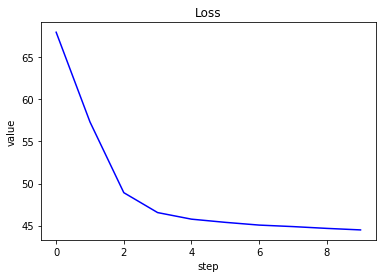

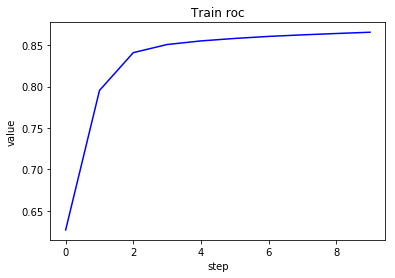

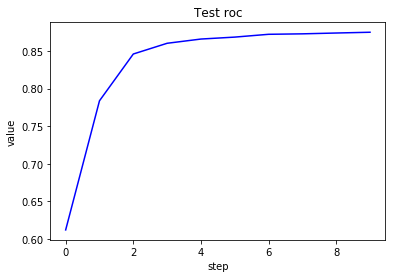

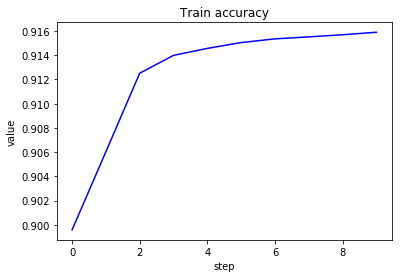

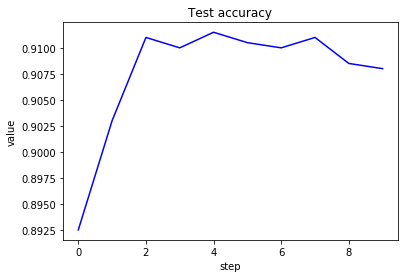

In [4]:
def show_figure(running_loss, title):
    x = np.array([i for i in range(len(running_loss))])
    y = np.array(running_loss)
    plt.figure()
    plt.plot(x, y, c='b')
    plt.axis()
    plt.title(title)
    plt.xlabel('step')
    plt.ylabel('value')
    plt.show()

show_figure(train_losses, 'Loss')
show_figure(train_rocs, 'Train roc')
show_figure(test_rocs, 'Test roc')
show_figure(train_accuracies, 'Train accuracy')
show_figure(test_accuracies, 'Test accuracy')

In [5]:
with torch.no_grad():
    model.eval()

    ids = []
    ones = 0
    zeros = 0
    res = evaluate(model, X=test_x_tensor, mode='Test')
    dataframe = pd.DataFrame({'ID_code': test_df.ID_code, 'target': res})
    dataframe.to_csv("result.csv", index=False, sep=',')
    print(dataframe)

            ID_code    target
0            test_0  0.176798
1            test_1  0.315358
2            test_2  0.072592
3            test_3  0.149532
4            test_4  0.051118
5            test_5  0.009985
6            test_6  0.012215
7            test_7  0.093146
8            test_8  0.006897
9            test_9  0.013564
10          test_10  0.117713
11          test_11  0.117769
12          test_12  0.141268
13          test_13  0.010101
14          test_14  0.021106
15          test_15  0.034388
16          test_16  0.231952
17          test_17  0.014844
18          test_18  0.103201
19          test_19  0.035062
20          test_20  0.245285
21          test_21  0.071156
22          test_22  0.021370
23          test_23  0.028503
24          test_24  0.083491
25          test_25  0.021953
26          test_26  0.041413
27          test_27  0.014977
28          test_28  0.054742
29          test_29  0.241326
...             ...       ...
199970  test_199970  0.156679
199971  te